In [96]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
import matplotlib.pyplot as plt 
import numpy as np

from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram
from sklearn.cluster import AgglomerativeClustering
import statsmodels.api as sm
## Library 1

from sktime.distances.elastic_cython import dtw_distance
from scipy.cluster.hierarchy import fcluster
from sklearn import metrics

from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis


from collections import Counter

## Library 2
# from dtw import *




Importing the industry wise stocks for companies in the timezone where the new tariffs were introduced.




In [169]:
companies = ['TSLA']

yahoo_financials = YahooFinancials(companies)

data = yahoo_financials.get_historical_price_data(start_date='2019-01-01',
                                                  end_date='2019-12-31',
                                                  time_interval='daily')

prices_df = pd.DataFrame({
    a: {x['formatted_date']: x['adjclose'] for x in data[a]['prices']} for a in companies
})

prices_df


,TSLA
2019-01-02,62.023998
2019-01-03,60.071999
2019-01-04,63.537998
2019-01-07,66.991997
2019-01-08,67.070000
...,...
2019-12-23,83.844002
2019-12-24,85.050003
2019-12-26,86.188004
2019-12-27,86.075996


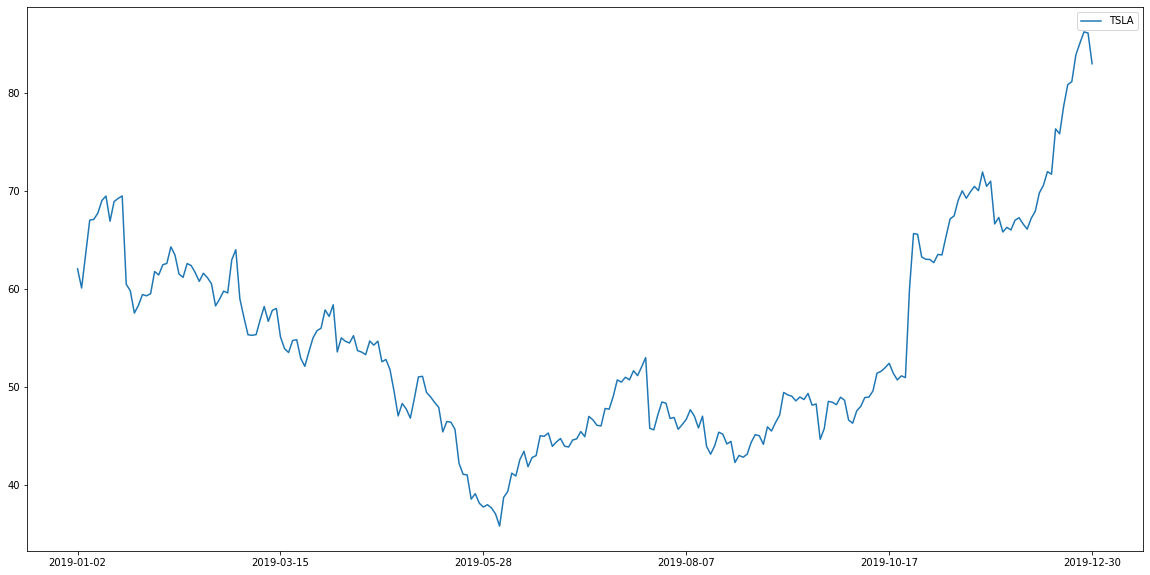

In [170]:
fig, ax = plt.subplots(figsize=(20,10))
prices_df.plot(ax=ax)

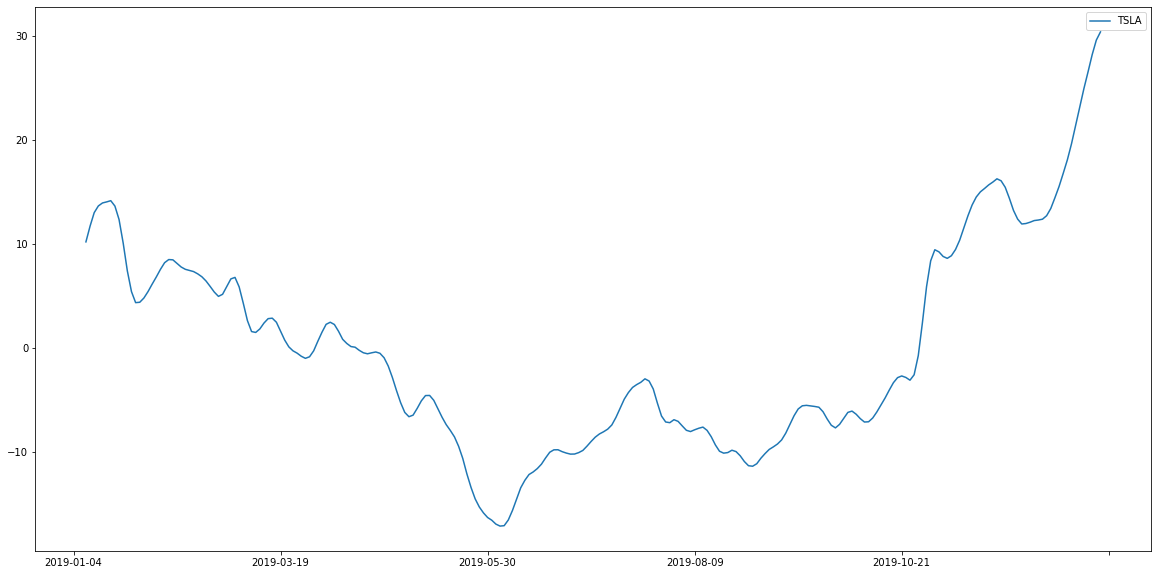

In [226]:
fig, ax = plt.subplots(figsize=(20,10))

cols = list(prices_df.columns)
lowess = sm.nonparametric.lowess

for col in cols:
    prices_df[col] = (prices_df[col]) - np.mean((prices_df[col]))
    prices_df[col] = prices_df[col].rolling(window=4).mean()
    
    
prices_df.plot(ax=ax)

In [258]:
# prices_dict = prices_df.to_dict('series')
# prices_df = np.array_split(prices_df, 10)
prices_df.dropna(inplace=True)

chunk_size = int(prices_df.shape[0] / 40)
i = 0

og_prices_dict = {}

for start in range(0, prices_df.shape[0], chunk_size):
    df_subset = prices_df.iloc[start:start + chunk_size]
    df_subset = (df_subset) - np.mean((df_subset))

    df_subset.columns = ['TSLA'+str(i)]
    new_prices_dict = df_subset.to_dict('series')
    og_prices_dict.update(new_prices_dict)
    i = i + 1
print(og_prices_dict) 

{'TSLA0': 2019-01-09   -2.557835
2019-01-10   -1.046501
2019-01-11    0.249333
2019-01-14    0.893168
2019-01-15    1.180668
2019-01-16    1.281167
Name: TSLA0, dtype: float64, 'TSLA1': 2019-01-17    3.646667
2019-01-18    3.129833
2019-01-22    1.836500
2019-01-23   -0.432000
2019-01-24   -3.094833
2019-01-25   -5.086166
Name: TSLA1, dtype: float64, 'TSLA2': 2019-01-28   -0.965611
2019-01-29   -0.930445
2019-01-30   -0.520611
2019-01-31    0.097889
2019-02-01    0.815723
2019-02-04    1.503056
Name: TSLA2, dtype: float64, 'TSLA3': 2019-02-05   -0.547194
2019-02-06    0.089639
2019-02-07    0.390972
2019-02-08    0.364472
2019-02-11    0.026139
2019-02-12   -0.324028
Name: TSLA3, dtype: float64, 'TSLA4': 2019-02-13    0.434722
2019-02-14    0.321722
2019-02-15    0.216222
2019-02-19   -0.003111
2019-02-20   -0.282111
2019-02-21   -0.687445
Name: TSLA4, dtype: float64, 'TSLA5': 2019-02-22    0.259388
2019-02-25   -0.283611
2019-02-26   -0.695945
2019-02-27   -0.496944
2019-02-28    0.23

In [259]:
distanceMatrix = np.empty((len(og_prices_dict), len(og_prices_dict),))
distanceMatrix[:] = np.nan

distanceMatrixDictionary = {}

for index1, (filter1, trajectory1) in enumerate(og_prices_dict.items()):
    
     for index2, (filter2, trajectory2) in enumerate(og_prices_dict.items()):
            
                unionFilter = str(filter1) + str(filter2)

                trajectory1 = np.asarray(trajectory1)
                trajectory2 = np.asarray(trajectory2)
                trajectory1 = trajectory1.reshape((-1, 1))
                trajectory2 = trajectory2.reshape((-1, 1))
                metric = dtw_distance(trajectory1, trajectory2)
                distanceMatrix[index1][index2] = metric
                distanceMatrixDictionary[unionFilter] = metric

D:\Program_Files\Anaconda\lib\site-packages\scipy\cluster\hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


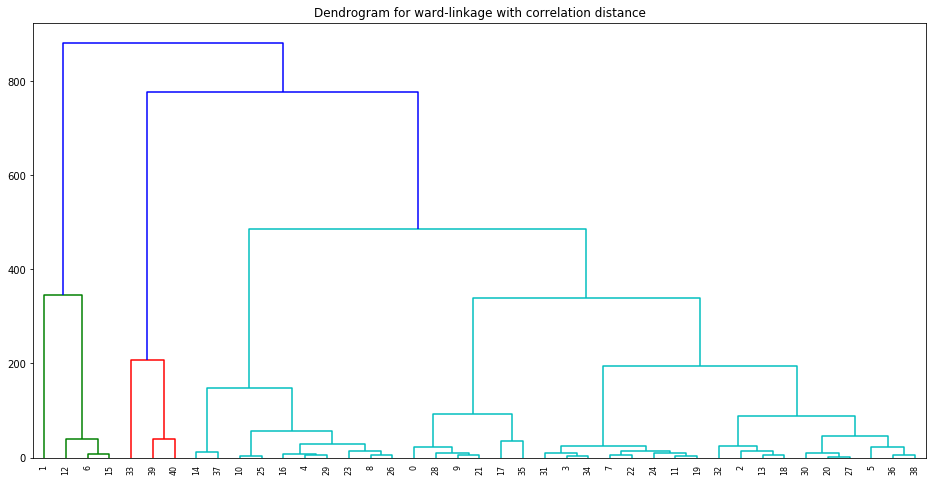

In [260]:
def hierarchical_clustering(distanceMatrix, method='ward'):
    if method == 'complete':
        Z = complete(distanceMatrix)
    if method == 'single':
        Z = single(distanceMatrix)
    if method == 'average':
        Z = average(distanceMatrix)
    if method == 'ward':
        Z = ward(distanceMatrix)
    
    fig = plt.figure(figsize=(16, 8))
    dn = dendrogram(Z)
    plt.title(f"Dendrogram for {method}-linkage with correlation distance")
    plt.show()
    
    return Z

linkage_matrix = hierarchical_clustering(distanceMatrix)

Add the cluster quality metrics 

Text(0.5, 1.0, 'calinski_harabasz_score')

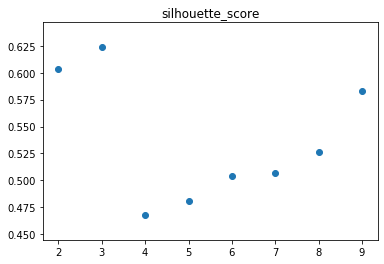

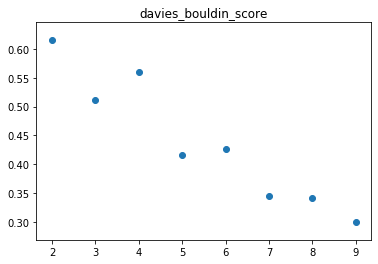

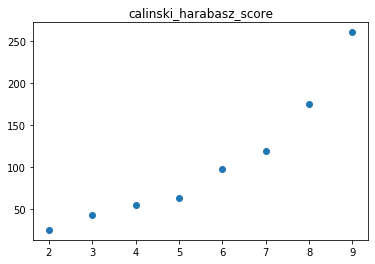

In [261]:
# distmatrix1 = scipy.spatial.distance.squareform(linkage_matrix + linkage_matrix.T)
# ddgm = scipy.cluster.hierarchy.linkage(distmatrix1, method="average")
# nodes = scipy.cluster.hierarchy.fcluster(ddgm, 4, criterion="maxclust")
fig,ax1 = plt.subplots()
fig,ax2 = plt.subplots()
fig,ax3 = plt.subplots()

scores1 = []
scores2 = []
scores3 = []
xax = []
for i in range(2,10):
    cluster_labels = fcluster(linkage_matrix, i, criterion='maxclust')
    score1 = metrics.silhouette_score(distanceMatrix + distanceMatrix.T , cluster_labels, metric='euclidean')
    score2 = metrics.davies_bouldin_score(distanceMatrix, cluster_labels)
    score3 = metrics.calinski_harabasz_score(distanceMatrix, cluster_labels)
    scores1.append(score1)
    scores2.append(score2)
    scores3.append(score3)
    xax.append(i)
    
ax1.scatter(xax,scores1)
ax1.set_title('silhouette_score')
ax2.scatter(xax,scores2)
ax2.set_title('davies_bouldin_score')
ax3.scatter(xax,scores3)
ax3.set_title('calinski_harabasz_score')


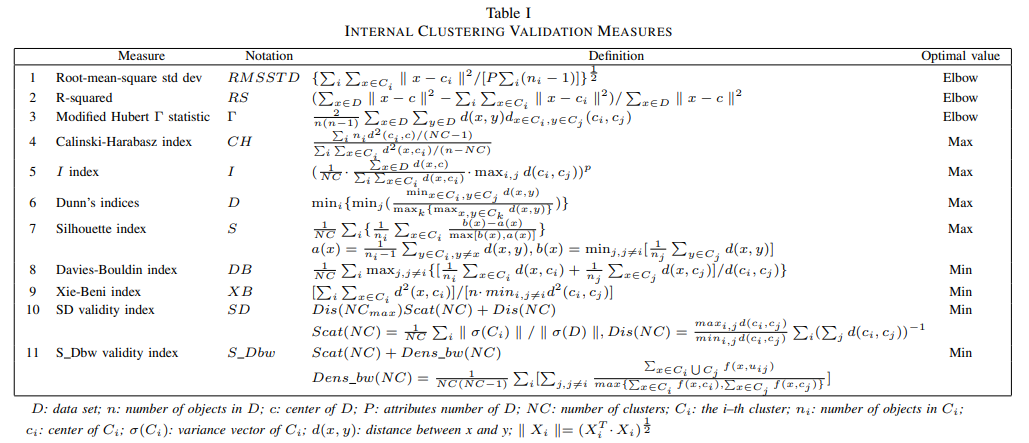

In [262]:
cluster_labels = fcluster(linkage_matrix, 8, criterion='maxclust')
f = np.expand_dims(distanceMatrix, 1)

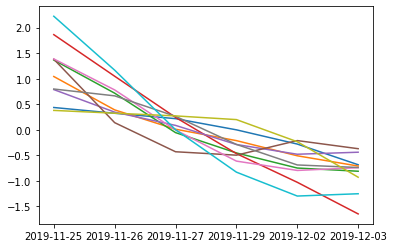

In [279]:
newdf = pd.DataFrame.from_dict(og_prices_dict)
newdf.reset_index(inplace=True)
mapping = {}
 
for index1, (filter1, trajectory1) in enumerate(og_prices_dict.items()): 
    mapping[filter1] = cluster_labels[index1]


keys = [k for k,v in mapping.items() if v == 5]    
fig1, ax1 = plt.subplots(1,1)

for i in keys:
    og_prices_dict[i].plot()

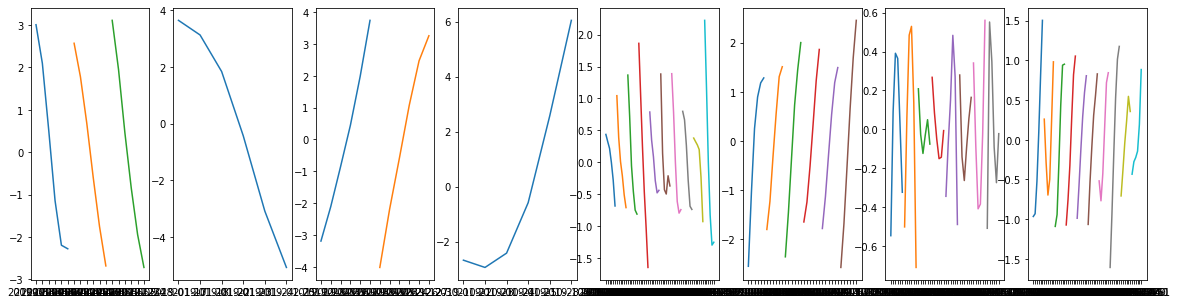

In [272]:
fig, ax1 = plt.subplots(1, int(len(np.unique(cluster_labels))),figsize=(20, 5))
z = 0

for row in ax1:
    keys = [k for k,v in mapping.items() if v == z+1]    
    z = z+1
    for i in keys:
        row.plot(og_prices_dict[i])

<BarContainer object of 8 artists>

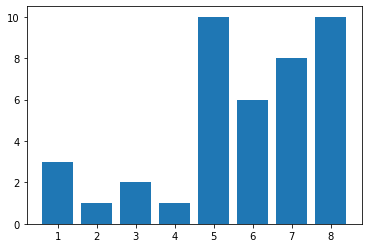

In [273]:
res = Counter(mapping.values())

keys = res.keys()
values = res.values()

plt.bar(keys, values)

As we can see the split of the trends and the number of observations for the same cluster. This gives an intuituion for the impact of the stock trend in the given time frame

As we can see the instances for the fall in the stock (cluster 5) are 10 while the instances where the stock which showed convex / concave behavior were 7.      

### dtaidistance Library

963.3370693086696


(<Figure size 720x720 with 4 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x2783df91c50>])

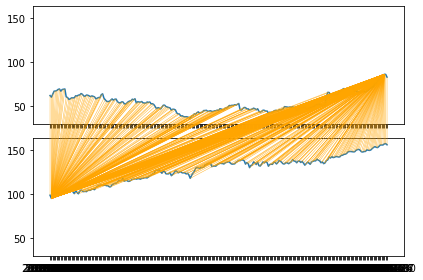

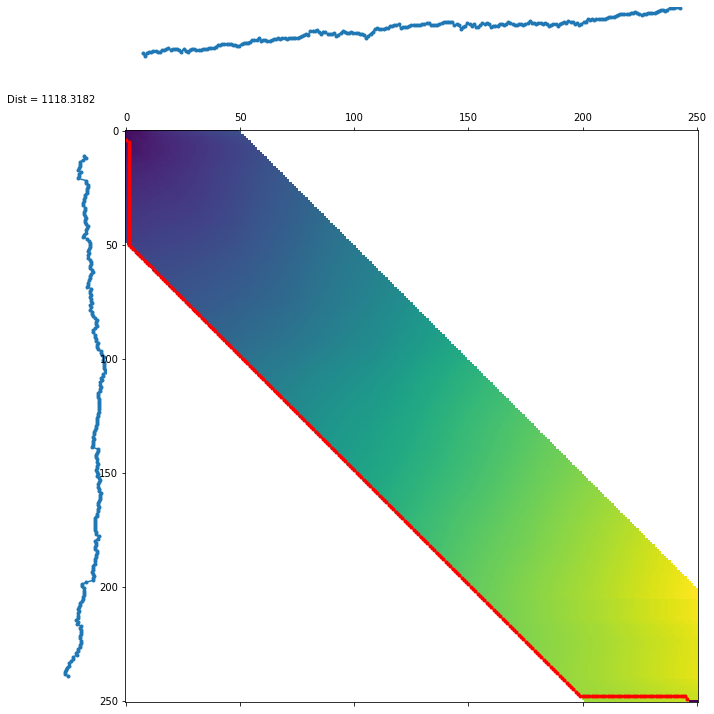

In [12]:
distance = dtw.distance(prices_df['TSLA'], prices_df['MSFT'], psi=1)

print(distance)
path = dtw.warping_path(prices_df['TSLA'], prices_df['MSFT'])
dtwvis.plot_warping(prices_df['TSLA'], prices_df['MSFT'], path)

d, paths = dtw.warping_paths(prices_df['TSLA'], prices_df['MSFT'], window=50, psi=4)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(prices_df['TSLA'], prices_df['MSFT'], paths, best_path)

### DTW from R library

In [ ]:
alignment = dtw(prices_df['TSLA'], prices_df['MSFT'], keep_internals=True)
alignment.plot(type="threeway")

dtw(prices_df['TSLA'], prices_df['MSFT'], keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2)

In [ ]:
distanceMatrixDictionary

In [ ]:
dendrogram(distanceMatrixDictionary,
            orientation='top',distance_sort='descending',
            show_leaf_counts=True)

In [88]:
x = distanceMatrix[numpy.logical_not(numpy.isnan(distanceMatrix))]

In [89]:
x

array([108.48621461, 156.58321063, 129.08114977, ...,  46.34995158,
        13.83620366,   9.65845512])

,index,TSLA
0,2019-01-04,7.287337
1,2019-01-07,8.943336
2,2019-01-08,11.276004
3,2019-01-09,12.665338
4,2019-01-10,13.332673
...,...,...
244,2019-12-23,27.332671
245,2019-12-24,28.746672
246,2019-12-26,30.436675
247,2019-12-27,31.180673


2      11.276004
3      12.665338
4      13.332673
5      14.126675
6      13.851340
         ...    
244    27.332671
245    28.746672
246    30.436675
247    31.180673
248    30.477339
Name: TSLA, Length: 247, dtype: float64